## Observational social learning task with a reinforcement-learning-based network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo

### Task is defined by the Environment node

In [2]:
class Environment():
    def __init__(self, prob_A, time_sample=1, dt=0.001, seed_env=4, dim_context=3):
        self.rng = np.random.RandomState(seed=seed_env)
        self.prob_A = prob_A
        self.prob_B = 1 - prob_A
        self.time_sample = time_sample
        self.dt = dt
        self.obs = 0
        self.weight = 0
        self.dim_context = dim_context
        self.context = self.rng.rand(self.dim_context)
        self.context = self.context / np.linalg.norm(self.context)
        self.alpha = 0.6  # todo: fit
        self.beta = 0.2  # todo: fit
        self.RD = [0.2, 0.6, 0.3]  # todo: read these values in from external data file
    def sample(self, t):
        if t % self.time_sample < self.dt:
            self.obs = 1 if self.rng.uniform(0,1) < self.prob_A else -1
            self.n_sample = int(t / self.time_sample) + 1
            if self.n_sample <= 1:
                self.weight = 1
            elif self.n_sample == 2:
                self.weight = self.alpha
            elif self.n_sample == 3:
                self.weight = self.beta * self.RD[0]
            elif self.n_sample == 4:
                self.weight = self.beta * self.RD[1]
            elif self.n_sample == 5:
                self.weight = self.beta * self.RD[2]
        return [self.obs, self.weight]

### Define the neural network

In [3]:
def build_network(env, n_neurons=500, seed_net=0, syn_feedback=0.1, learning_rate=1e-4):
    net = nengo.Network(seed=seed_net)
    func_obs = lambda t: env.sample(t)[0]
    func_weight = lambda t: env.sample(t)[1]
    func_context = lambda t: env.context
    func_error = lambda x: x[2] * (x[0] - x[1])
    # func_error = lambda x: x[2] * x[1] * -1
    func_choice = lambda x: -1 if x[0] < 0 else 1
    func_confidence = lambda x: np.abs(x[0])

    with net:
        # external inputs
        net.input_obs = nengo.Node(func_obs)
        net.input_weight = nengo.Node(func_weight)
        net.input_context = nengo.Node(func_context)
        # ensembles
        net.obs = nengo.Ensemble(n_neurons, 1)
        net.weight = nengo.Ensemble(n_neurons, 1)
        net.context = nengo.Ensemble(n_neurons*env.dim_context, env.dim_context)
        net.prediction = nengo.Ensemble(n_neurons, 1)
        net.combined = nengo.Ensemble(n_neurons*3, 3, radius=3)
        net.error = nengo.Ensemble(n_neurons, 1)
        net.decision = nengo.Ensemble(2*n_neurons, 2, radius=1.4)
        # connections
        nengo.Connection(net.input_obs, net.obs)
        nengo.Connection(net.input_weight, net.weight)
        nengo.Connection(net.input_context, net.context)
        net.conn = nengo.Connection(net.context, net.prediction,
                                    learning_rule_type=nengo.PES(learning_rate=learning_rate), function=lambda x: 0)
        nengo.Connection(net.prediction, net.combined[0])
        nengo.Connection(net.obs, net.combined[1])
        nengo.Connection(net.weight, net.combined[2])
        nengo.Connection(net.combined, net.error, function=func_error)
        nengo.Connection(net.error, net.conn.learning_rule)
        nengo.Connection(net.prediction, net.decision[0], function=func_choice)
        nengo.Connection(net.prediction, net.decision[1], function=func_confidence)
        # probes
        net.probe_input = nengo.Probe(net.input_obs, synapse=0)
        net.probe_obs = nengo.Probe(net.obs, synapse=0.01)
        net.probe_weight = nengo.Probe(net.weight, synapse=0.01)
        net.probe_prediction = nengo.Probe(net.prediction, synapse=0.01)
        net.probe_error = nengo.Probe(net.error, synapse=0.01)
        net.probe_decision = nengo.Probe(net.decision, synapse=0.01)
    return net

### Simulate the network for one observation

In [4]:
def simulate(time_sim, seed_sim=0):
    env = Environment(prob_A=0.8)
    net = build_network(env)
    sim = nengo.Simulator(net, seed=seed_sim)
    with sim:
        sim.run(time_sim)
    return net, sim

In [5]:
net, sim = simulate(time_sim=6)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

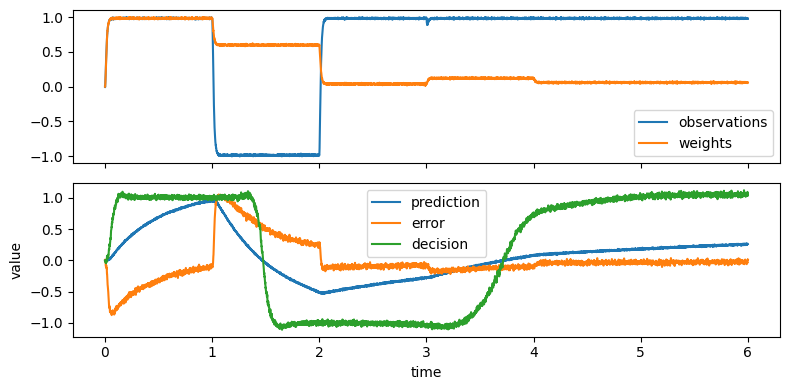

In [7]:
times = sim.trange().flatten()
input_obs = sim.data[net.probe_input].flatten()
obs = sim.data[net.probe_obs].flatten()
weights = sim.data[net.probe_weight].flatten()
pred = sim.data[net.probe_prediction].flatten()
err = sim.data[net.probe_error].flatten()
decision = sim.data[net.probe_decision][:,0].flatten()
confidence = sim.data[net.probe_decision][:,1].flatten()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,4), sharex=True)
# sns.lineplot(x=times, y=input_obs, ax=ax, label='true observations', color='k')
sns.lineplot(x=times, y=obs, ax=axes[0], label='observations')
sns.lineplot(x=times, y=weights, ax=axes[0], label='weights')
sns.lineplot(x=times, y=pred, ax=axes[1], label='prediction')
sns.lineplot(x=times, y=err, ax=axes[1], label='error')
sns.lineplot(x=times, y=decision, ax=axes[1], label='decision')
# sns.lineplot(x=times, y=confidence, ax=ax, label='confidence')
axes[1].set(xlabel='time', ylabel='value')
# axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()